In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import scipy.special

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import triangle as tr
from scipy.optimize import minimize

In [2]:
def bezier(segment, t):
    x = segment[:,0]
    y = segment[:,1]
    
    n = segment.shape[0] - 1
    s = np.array([0,0])
    for i in range(n+1):
        s = s + scipy.special.comb(n, i) * np.power(1. -t, n-i) * np.power(t, i) * np.array([x[i], y[i]])
    return s

def bezierCurve(segment, dn = 32):
    dt = 1. / (dn - 1.)
    curve = []
    for i in range(dn):
        curve.append(bezier(segment, dt * i))
    curve = np.array(curve)
    return curve

def makeC1(segments):
    s = np.copy(segments)
    
    for i in range(s.shape[0]):
        s[i,1,:] = 2. * s[i-1,3,:] - s[i-1,2,:]
    return s
def makeC2(segments):
    # Could be better: https://math.stackexchange.com/questions/2625574/c2-continuous-bezier-contour
    Pk = np.array(segments)[:,0,:]
    P = np.vstack((Pk, Pk[0,:]))
    B = np.zeros_like(Pk)
    C = np.zeros_like(Pk)
    A = np.zeros_like(P)

    for k in range(Pk.shape[0]):
        B[k,:] = 1. / 3. * (2. * P[k,:] + P[k+1,:])
        C[k,:] = 1. / 3. * ( P[k,:] + 2. * P[k+1,:])
        
    for k in range(Pk.shape[0]):
        A[k,:] = 1./2. * (C[k-1,:] + B[k,:])
    A[-1,:] = A[0]
    
    segments_c2 = np.copy(segments)
    segments_c2[:,:,:] = 0.
    for i in range(segments_c2.shape[0]):
        segments_c2[i,0,:] = A[i,:]
        segments_c2[i,1,:] = B[i,:]
        segments_c2[i,2,:] = C[i,:]
        segments_c2[i,3,:] = A[i+1,:]
        
    return segments_c2


In [3]:
def genCurves(seed = 0, n = 8, thetaScale = 8., rScale = 0.5, r2Scale = 2.):
    np.random.seed(seed)

    dtheta = 2. * np.pi / (n - 1)
    theta = np.clip(np.random.normal(loc = dtheta / 2., scale = dtheta / thetaScale, size = n-1),0,dtheta) + np.arange(n-1) * dtheta

    r = np.random.normal(loc = 1., scale = rScale, size = n-1)

    segments = []
    for i in range(n-2):
        segments.append(np.array([[theta[i], r[i]],[0,0],[0,0],[theta[i+1],r[i+1]]]))
    segments.append(np.array([[theta[-1],r[-1]],[0,0],[0,0],[theta[0],r[0]]]))

    for s in segments:
        theta = s[:,0]
        r = s[:,1]

        dangle = theta[-1] - theta[0] if theta[-1] > theta[0] else np.fmod(2. * np.pi + (theta[-1] - theta[0]), 2. * np.pi)
        rmin = np.min((r[-1], r[0]))
        dr = np.abs(r[-1] - r[0])

        rRand = np.random.normal(loc = rmin + dr / 2., scale = dr / r2Scale, size=2)

        thetaRand = np.random.uniform(low = theta[0], high = theta[0] + dangle, size = 2)
        thetaRand = np.sort(thetaRand)

        s[1:3,0] = thetaRand
        s[1:3,1] = rRand


    for s in segments:
        theta = s[:,0]
        r = s[:,1]
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        s[:,0] = x
        s[:,1] = y

    segments_c1 = makeC1(segments)
    segments_c2 = makeC2(segments)

    return segments, segments_c1, segments_c2

In [4]:
def getLs(segments):
    ls = []
    for s in segments:
        curve = bezierCurve(s, dn = 100)
        c0 = curve[:curve.shape[0] - 1]
        c1 = curve[1:]
        d = c1 - c0
        l = np.linalg.norm(d,axis=1).sum()
        ls.append(l)
    ls = np.array(ls)
    return ls
def evalBezier(t, ls, segments):
    length = ls.sum()
    lcs = np.cumsum(ls)
    lt = t * length
    index = np.argmax(lcs >= lt)
    offset = 0. if index == 0 else lcs[index - 1]
    lrel = (lt - offset) / ls[index]
    return bezier(segments[index], lrel)
def buildRegularPolygon(segments, nb):
    ls = getLs(segments)    
#     print(ls)
    points = []
    for i in range(nb):
        points.append(evalBezier(i / nb, ls, segments))
    points.append(points[0])
    points = np.array(points)
    
    return points

<IPython.core.display.Javascript object>


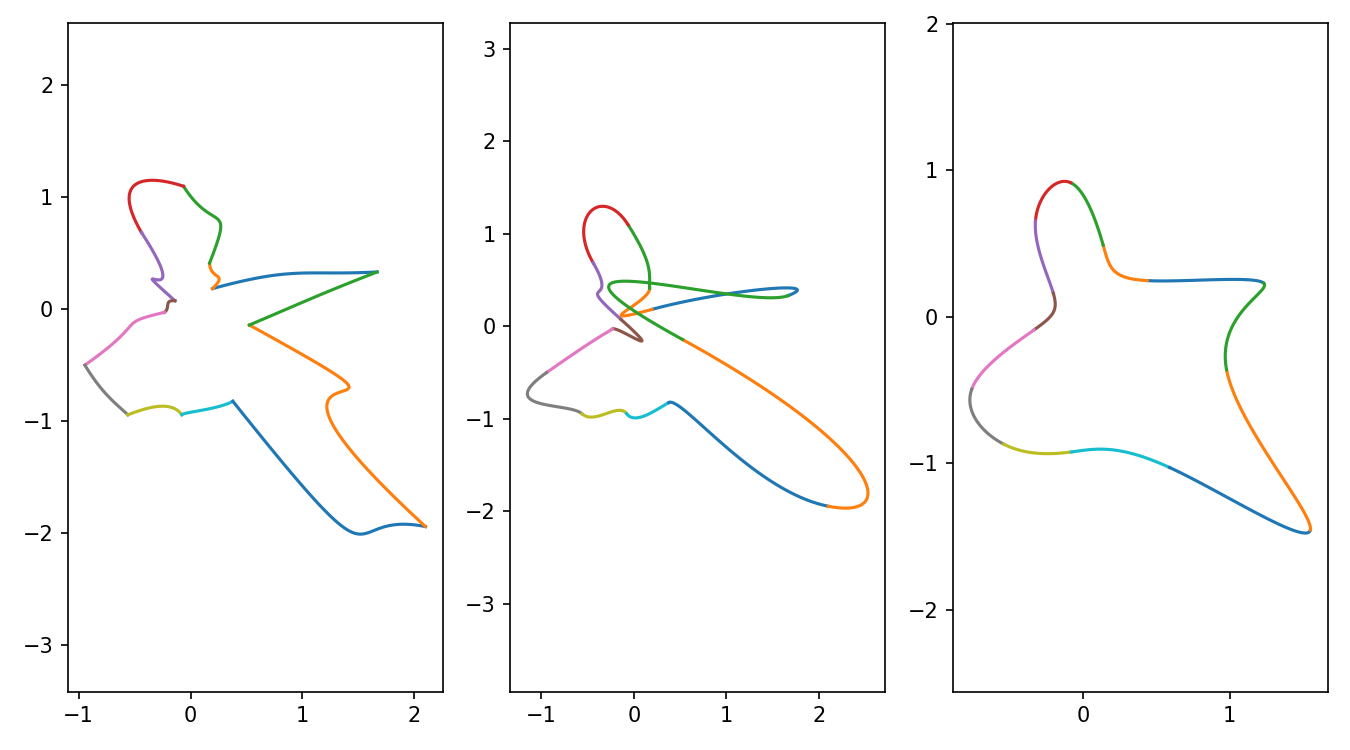

In [6]:
segments, segments_c1, segments_c2 = genCurves(seed = 7361, n = 14, thetaScale = 10.6, rScale = 0.65)

fig, axs = plt.subplots(1,3, figsize = (9,5))
for s in segments:
    curve = bezierCurve(s, dn = 100)
    axs[0].plot(curve[:,0], curve[:,1])
    axs[0].axis('equal')
for s in segments_c1:
    curve = bezierCurve(s, dn = 100)
    axs[1].plot(curve[:,0], curve[:,1])
    axs[1].axis('equal')
for s in segments_c2:
    curve = bezierCurve(s, dn = 100)
    axs[2].plot(curve[:,0], curve[:,1])
    axs[2].axis('equal')
    
fig.tight_layout()

<IPython.core.display.Javascript object>


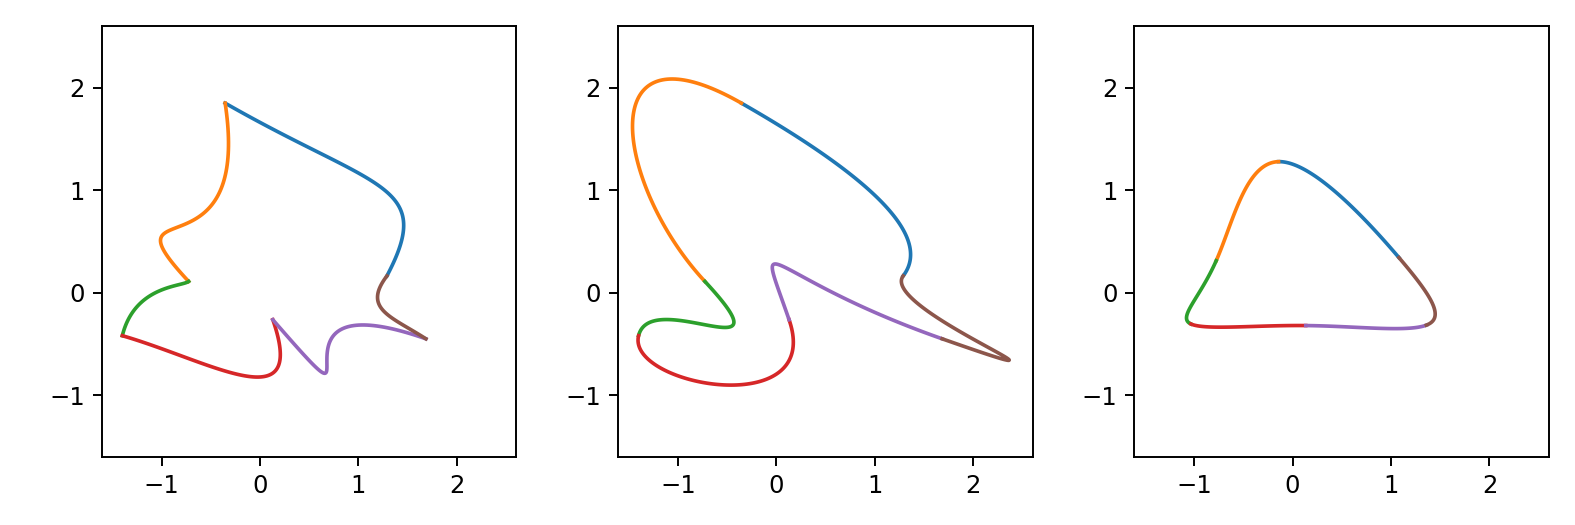

interactive(children=(IntSlider(value=259, description='seed', max=1024), IntSlider(value=7, description='n', …

<function __main__.f(seed=0, n=8, thetaScale=8.0, rScale=0.5, r2Scale=2.0)>

In [83]:
nmax = 16
segments, segments_c1, segments_c2 = genCurves(seed = 2, n = nmax)
n = nmax
dn = 100
blank = np.zeros((dn,2))
c0_plots = {}
c1_plots = {}
c2_plots = {}

fig, axs = plt.subplots(1,3, figsize = (9,3))
for i in range(nmax - 1):
    curve_0 = bezierCurve(segments[i], dn = dn)
    curve_1 = bezierCurve(segments_c1[i], dn = dn)
    curve_2 = bezierCurve(segments_c2[i], dn = dn)
    
    
    c0_plots[i] = axs[0].plot(curve_0[:,0],curve_0[:,1])[0]
    c1_plots[i] = axs[1].plot(curve_1[:,0],curve_1[:,1])[0]
    c2_plots[i] = axs[2].plot(curve_2[:,0],curve_2[:,1])[0]
    
# axs[0].axis('equal')
# axs[1].axis('equal')
# axs[2].axis('equal')


def f(seed = 0, n = 8, thetaScale = 8., rScale = 0.5, r2Scale = 2.):
    global segments, segments_c1, segments_c2
    segments, segments_c1, segments_c2 = genCurves(seed = seed, n = n, thetaScale = thetaScale, rScale = rScale, r2Scale = r2Scale)
    xmin = 1e10;
    xmax = -1e10;
    ymin = 1e10;
    ymax = -1e10;
    for i in range(nmax - 1):
        plot = c0_plots[i]
        if i < n - 1:  
            curve = bezierCurve(segments[i], dn = 100)  
            xmin = min(xmin, np.min(curve[:,0]))
            xmax = max(xmax, np.max(curve[:,0]))
            ymin = min(ymin, np.min(curve[:,1]))
            ymax = max(ymax, np.max(curve[:,1]))
            
            plot.set_xdata(curve[:,0])
            plot.set_ydata(curve[:,1])
        else:
            plot.set_xdata(blank[:,0])
            plot.set_ydata(blank[:,1])
            
    for i in range(nmax - 1):
        plot = c1_plots[i]
        if i < n - 1:  
            curve = bezierCurve(segments_c1[i], dn = 100)  
            xmin = min(xmin, np.min(curve[:,0]))
            xmax = max(xmax, np.max(curve[:,0]))
            ymin = min(ymin, np.min(curve[:,1]))
            ymax = max(ymax, np.max(curve[:,1]))
            plot.set_xdata(curve[:,0])
            plot.set_ydata(curve[:,1])
        else:
            plot.set_xdata(blank[:,0])
            plot.set_ydata(blank[:,1])

    for i in range(nmax - 1):
        plot = c2_plots[i]
        if i < n - 1:  
            curve = bezierCurve(segments_c2[i], dn = 100)  
            xmin = min(xmin, np.min(curve[:,0]))
            xmax = max(xmax, np.max(curve[:,0]))
            ymin = min(ymin, np.min(curve[:,1]))
            ymax = max(ymax, np.max(curve[:,1]))
            plot.set_xdata(curve[:,0])
            plot.set_ydata(curve[:,1])
        else:
            plot.set_xdata(blank[:,0])
            plot.set_ydata(blank[:,1])

    
    axs[0].set_xlim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    axs[0].set_ylim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    axs[1].set_xlim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    axs[1].set_ylim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    axs[2].set_xlim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    axs[2].set_ylim([min(xmin,ymin)  * 1.1, max(xmax,ymax) * 1.1])
    fig.canvas.draw()
    fig.canvas.flush_events()
        
fig.tight_layout()

interact(f, 
         seed = widgets.IntSlider(min = 0, max = 1024, step = 1, value = 259),
         n = widgets.IntSlider(min=2, max = 16, step=1, value = 7),
         thetaScale = widgets.FloatSlider(min = 0.01, max = 2., step = 0.01, value = 1.67),
         rScale = widgets.FloatSlider(min = 0.01, max = 1., step = 0.01, value = 0.72),
         r2Scale = widgets.FloatSlider(min = 0.5, max = 16., step = 0.1, value = 1.4)
        )

In [84]:
shape = segments_c2

In [85]:
ls = getLs(shape)
n = 32
samples = np.linspace(0,1.,n)
samples = samples[1:-2]


def getLoss(x):
    samples = np.copy(x)
    samples = np.sort(samples)
    samples = np.hstack((0,samples))
    samples = np.hstack((samples,0))
    points = []
    for t in samples:
        points.append(evalBezier(t, ls, shape))
    points = np.array(points)
    p0 = points[:points.shape[0]-1]
    p1 = points[1:]
    d = p1 - p0
    l = np.linalg.norm(d, axis =1)

    avgDistance = np.average(l)
    diff = l - avgDistance
    loss = np.sqrt(diff**2).sum()
    
    return loss

print(getLoss(samples))

res = minimize(getLoss, samples, method='BFGS', options={'disp':True})
# res = minimize(getLoss, res.x, method='BFGS', options={'disp':True})

1.6150479288009154
         Current function value: 0.000066
         Iterations: 163
         Function evaluations: 7632
         Gradient evaluations: 254


[0.03152576 0.06077787 0.08932222 0.1183346  0.14913435 0.18384498
 0.22700263 0.27017603 0.30643545 0.33744338 0.36635565 0.39535266
 0.42161541 0.44340173 0.47248281 0.55196427 0.59126363 0.62196797
 0.64920463 0.67478123 0.69994108 0.72617956 0.75321706 0.7820704
 0.81459204 0.8557859  0.91841887 0.95676538 0.98089249]


<IPython.core.display.Javascript object>


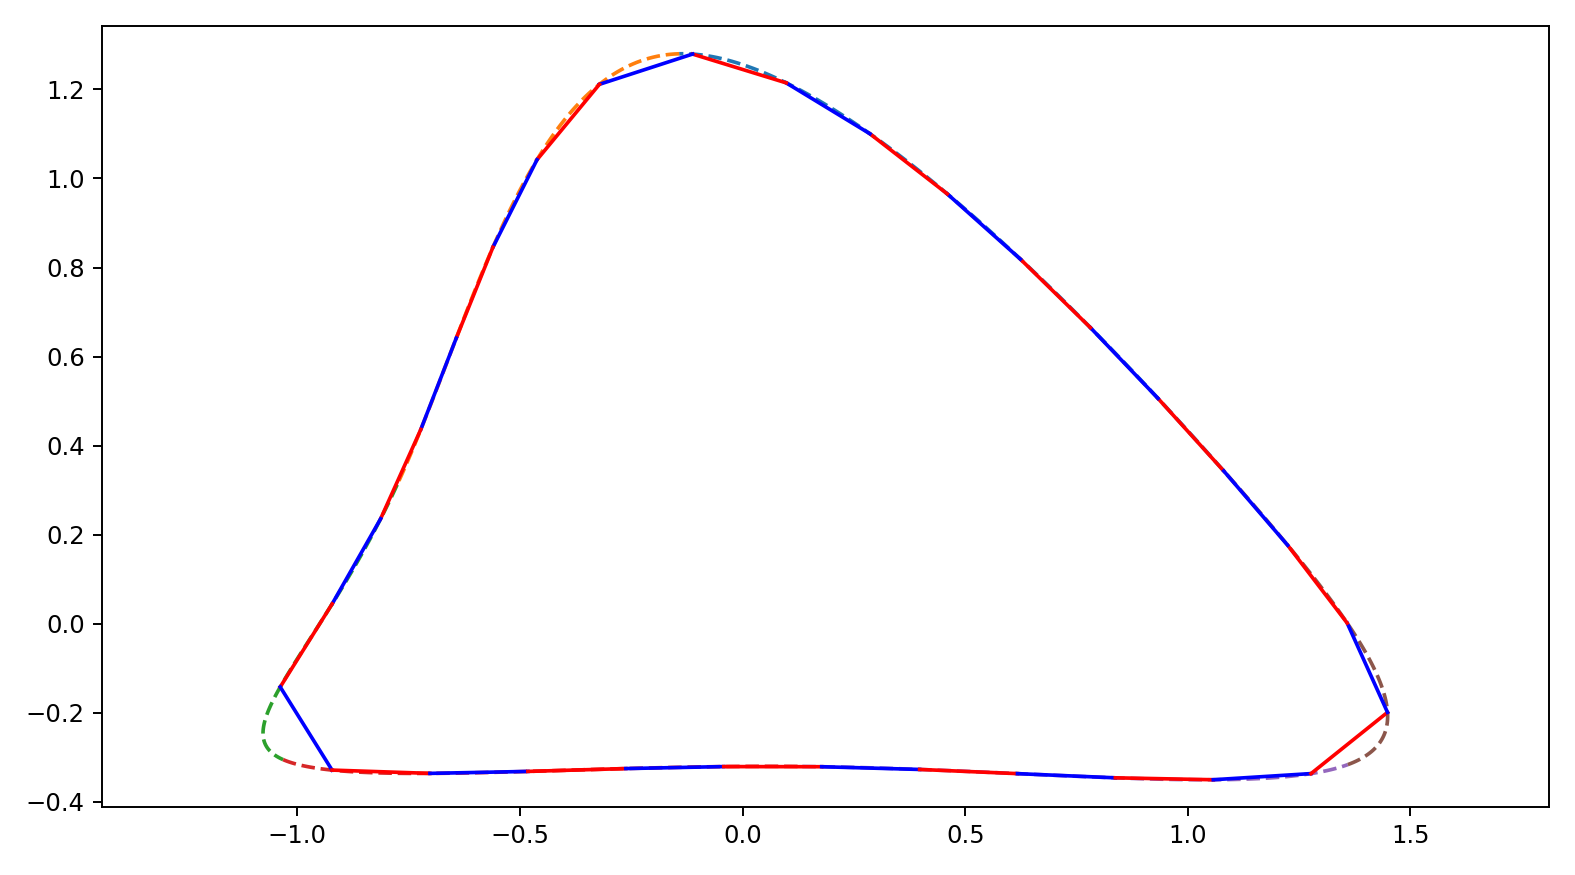

In [86]:
samples = res.x
samples = np.sort(samples)
print(samples)
samples = np.hstack((0,samples))
samples = np.hstack((samples,0))
points = []
for t in samples:
    points.append(evalBezier(t, ls, shape))
points = np.array(points)

# points = buildRegularPolygon(shape, 32)

fig, axs = plt.subplots(1,1, figsize = (9,5))
for s in shape:
    curve = bezierCurve(s, dn = 100)
    axs.plot(curve[:,0], curve[:,1], ls = '--')
for i in range(points.shape[0] - 1):
    axs.plot([points[i,0], points[i+1,0]], [points[i,1], points[i+1,1]], color = 'red' if i%2 == 0 else 'blue', alpha = 1.)
#     axs.plot([points[i,0], points[i+1,0]], [points[i,1], points[i+1,1]], color = 'black', alpha = 1.)

axs.axis('equal')
fig.tight_layout()

<IPython.core.display.Javascript object>


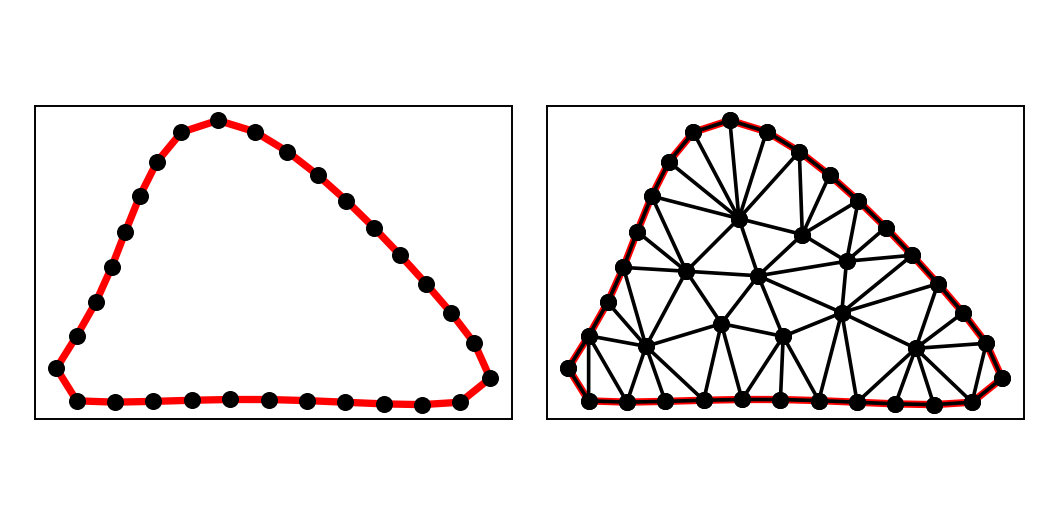

In [87]:
vertices = points
vertices = vertices[:vertices.shape[0] - 1,:]
segs = np.vstack((np.arange(vertices.shape[0]), np.arange(vertices.shape[0]) + 1))
segs = segs.transpose()
segs[segs == vertices.shape[0]] = 0
A = dict(vertices=vertices, segments=  segs)
B = tr.triangulate(A, 'pqsa0.1')
tr.compare(plt, A, B)
plt.show()


<IPython.core.display.Javascript object>


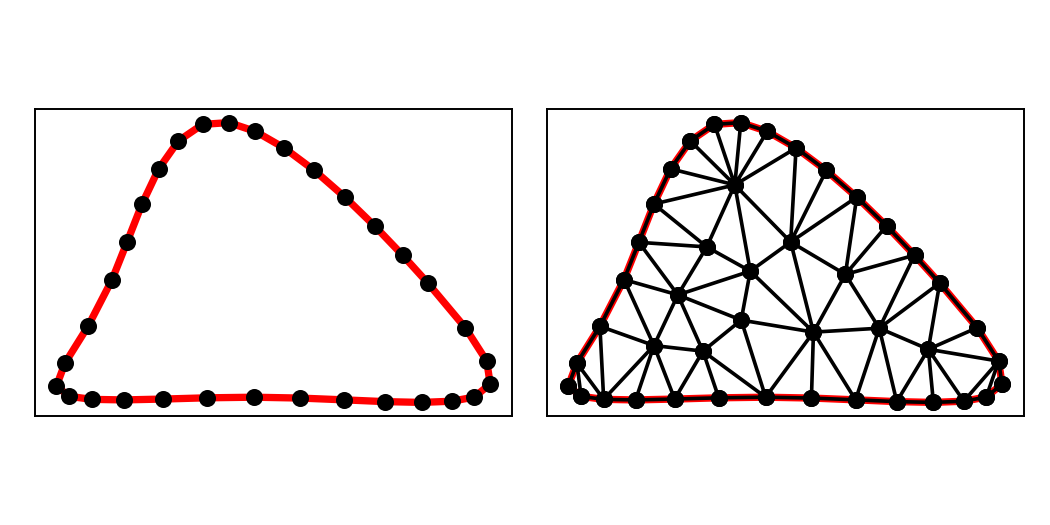

In [88]:
vertices = buildRegularPolygon(shape, n)
vertices = vertices[:vertices.shape[0] - 1,:]
segs = np.vstack((np.arange(vertices.shape[0]), np.arange(vertices.shape[0]) + 1))
segs = segs.transpose()
segs[segs == vertices.shape[0]] = 0
A = dict(vertices=vertices, segments=  segs)
B = tr.triangulate(A, 'pqsa0.1')
tr.compare(plt, A, B)
plt.show()

<IPython.core.display.Javascript object>


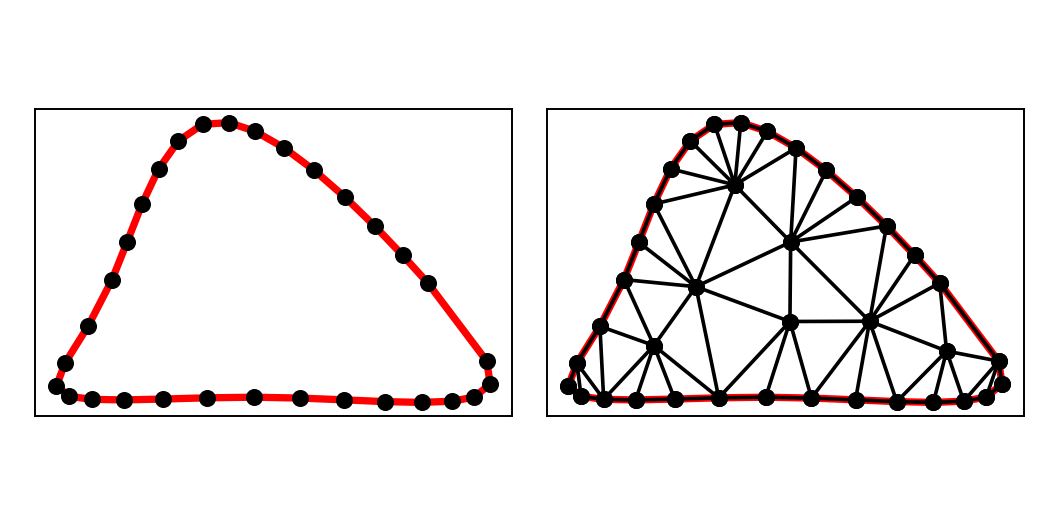

In [92]:
xmi = np.min(vertices[:,0])
xma = np.max(vertices[:,0])

ymi = np.min(vertices[:,1])
yma = np.max(vertices[:,1])

xcenter = (xma + xmi) / 2.
dx = xma - xmi
ycenter = (yma + ymi) / 2.
dy = yma - ymi

vtcs = np.copy(vertices)
vtcs[:,0] -= xcenter
vtcs[:,1] -= ycenter

xmi = np.min(vtcs[:,0])
xma = np.max(vtcs[:,0])

ymi = np.min(vtcs[:,1])
yma = np.max(vtcs[:,1])

xcenter = (xma + xmi) / 2.
dx = xma - xmi
ycenter = (yma + ymi) / 2.
dy = yma - ymi

scale = max(dx,dy)
vtcs /= scale
vtcs /= 3
vtcs[:,1] += 0.3
vtcs[:,0] -= 1.0

xmi = np.min(vtcs[:,0])
xma = np.max(vtcs[:,0])

ymi = np.min(vtcs[:,1])
yma = np.max(vtcs[:,1])

xcenter = (xma + xmi) / 2.
dx = xma - xmi
ycenter = (yma + ymi) / 2.
dy = yma - ymi

vtcs = vtcs[:vertices.shape[0] - 1,:]
segs = np.vstack((np.arange(vtcs.shape[0]), np.arange(vtcs.shape[0]) + 1))
segs = segs.transpose()
segs[segs == vtcs.shape[0]] = 0
A = dict(vertices=vtcs, segments=  segs)
B = tr.triangulate(A, 'pqsa0.1')
tr.compare(plt, A, B)
plt.show()


In [93]:
B['triangles']
print('triangles:')
for t in B['triangles']:
    i0, i1, i2 = t
#     print(B['vertices'][i0], B['vertices'][i1], B['vertices'][i2])
    print('    - v0: [', B['vertices'][i0][0], ', ', B['vertices'][i0][1], ']')
    print('      v1: [', B['vertices'][i1][0], ', ', B['vertices'][i1][1], ']')
    print('      v2: [', B['vertices'][i2][0], ', ', B['vertices'][i2][1], ']')
    
print('')

triangles:
    - v0: [ -1.1666666666666667 ,  0.20509382045260638 ]
      v1: [ -1.1568506005954104 ,  0.19713193185628763 ]
      v2: [ -1.160094434006005 ,  0.22268498358411254 ]
    - v0: [ -1.160094434006005 ,  0.22268498358411254 ]
      v1: [ -1.1568506005954104 ,  0.19713193185628763 ]
      v2: [ -1.1394945844428586 ,  0.1948255482415227 ]
    - v0: [ -1.0510589172549327 ,  0.19600877136474165 ]
      v1: [ -1.0686007157467656 ,  0.2814156228342053 ]
      v2: [ -1.1008542992543742 ,  0.23617415330173797 ]
    - v0: [ -1.1394945844428586 ,  0.1948255482415227 ]
      v1: [ -1.114964750623265 ,  0.19439510893856526 ]
      v2: [ -1.1008542992543742 ,  0.23617415330173797 ]
    - v0: [ -1.0849299209546248 ,  0.19505229097158255 ]
      v1: [ -1.1008542992543742 ,  0.23617415330173797 ]
      v2: [ -1.114964750623265 ,  0.19439510893856526 ]
    - v0: [ -0.8812612255283618 ,  0.2842324173169353 ]
      v1: [ -0.9351497986419072 ,  0.2548695175149312 ]
      v2: [ -0.87595881836341